In [2]:
# !/usr/bin/env python.
# -*- coding: utf-8 -*-

"""
Name:  filter and correct unreliable/reliable PWS

How to cite:
https://doi.org/10.5281/zenodo.4501920

Reference paper:

Bárdossy, A., Seidel, J., and El Hachem, A.: 
The use of personal weather station observations to improve precipitation estimation and interpolation,
Hydrol. Earth Syst. Sci., 25, 583–601, https://doi.org/10.5194/hess-25-583-2021, 2021.

"""

__author__ = "Abbas El Hachem", "Micha Eisele", "Jochen Seidel", "Andras Bardossy"
__copyright__ = 'Institut fuer Wasser- und Umweltsystemmodellierung - IWS'
__email__ = "abbas.el-hachem@iws.uni-stuttgart.de"

# =============================================================================

#from pathlib import Path

import os
import time
import timeit
import pyproj
import tqdm
import scipy.special
import xarray as xr

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from pathlib import Path
from pyproj import Transformer
from scipy.spatial import cKDTree
from scipy.stats import pearsonr as prs

from scipy import spatial as scsp
from scipy.stats import rankdata



In [3]:
   
def read_pcp_csv_file(path_to_file, sep_type, index_col):
    '''
    Read csv file and return df data
    '''
    
    in_df = pd.read_csv(path_to_file, sep=sep_type,
                        index_col=index_col,
                       encoding='latin-1')
    in_df.index = pd.to_datetime(in_df.index,
                                 format='%Y-%m-%d %H:%M:%S')
    return in_df



In [4]:
def read_metadata_csv_file(path_to_file, sep_type, index_col):
    '''
    Read metadata csv file and return df coords also in utm
    '''
    
    df_coords = pd.read_csv(path_to_file, sep=sep_type,
                        index_col=index_col,
                       encoding='latin-1')
    
    lon_vals = df_coords.loc[:, 'lon'].values.ravel()
    lat_vals = df_coords.loc[:, 'lat'].values.ravel()
    
    # convert to utm32 for distance calculation
    x_vals, y_vals = LatLon_To_XY(lon_vals, lat_vals)

    stn_ids = [str(ii) for ii in range(len(lon_vals))]
    # make a df and combine all info
    df_coords_utm32 = pd.DataFrame(
            index=stn_ids,
            data=lon_vals, columns=['lon'])
    df_coords_utm32['lat'] = lat_vals
    
    df_coords_utm32['X'] = x_vals
    df_coords_utm32['Y'] = y_vals
    
    coords_xy = np.array([(x, y) for x, y in zip(
        df_coords_utm32.loc[:, 'X'].values,
        df_coords_utm32.loc[:, 'Y'].values)])

    # create a tree from coordinates
    # coords_points_tree = cKDTree(coords_xy)
    
    return df_coords_utm32, coords_xy


In [5]:
def plot_pws_prim_netz_loc(lon_pws, lat_pws,
                          lon_prim1, lat_prim1,
                          lon_prim2=None,
                           lat_prim2=None):
    """ plot coordinates of stations"""
    plt.figure(dpi=100)
    plt.scatter(lon_pws, lat_pws, c='r', label='PWS')
    plt.scatter(lon_prim1, lat_prim1, c='b', label='Primary Netw.')
    if lon_prim2 is not None:
        plt.scatter(lon_prim2, lat_prim2, c='g', label='Primary Netw.2')
    plt.legend(loc=0)
    plt.grid()
    plt.show()
    return

In [6]:
def plot_pws_prim_netz_loc_AMS(lon_pws, lat_pws,
                          lon_prim1, lat_prim1,
                          lon_prim2=None,
                           lat_prim2=None):
    """ plot coordinates of stations around AMW"""
    plt.figure(dpi=100)
    plt.scatter(lon_pws, lat_pws, c='r', label='PWS', marker='o')
    plt.scatter(lon_prim1, lat_prim1, c='b', label='Primary Netw.', marker='d')
    if lon_prim2 is not None:
        plt.scatter(lon_prim2, lat_prim2, c='g', label='Primary Netw.2', marker='x')
    plt.xlim([min(lon_pws), max(lon_pws)])
    plt.ylim([min(lat_pws), max(lat_pws)])
    plt.legend(loc=0)
    plt.grid()
    plt.show()
    return

In [7]:

def resampleDf(df, agg, closed='right', label='right',
               shift=False, leave_nan=True,
               label_shift=None,
               temp_shift=0,
               max_nan=0):
    """
    Purpose: Aggregate precipitation data

    Parameters:
    -----------
    Df: Pandas DataFrame Object
        Data set
    agg: string
        Aggregation 'M':Monthly 'D': Daily, 'H': Hourly, 'Min': Minutely
    closed: string
        'left' or 'right' defines the aggregation interval
    label: string
        'left' or 'right' defines the related timestamp
    shift: boolean, optional
        Shift the values by 6 hours according to the dwd daily station.
        Only valid for aggregation into daily aggregations
        True, data is aggregated from 06:00 - 06:00
        False, data is aggregated from 00:00 - 00:00
        Default is False

    temp_shift: shift the data based on timestamps (+- 0 to 5), default: 0

    label_shift: shift time label by certain values (used for timezones)

    leave_nan: boolean, optional
        True, if the nan values should remain in the aggregated data set.
        False, if the nan values should be treated as zero values for the
        aggregation. Default is True

    Remark:
    -------
        If the timestamp is at the end of the timeperiod:

        Input: daily        Output: daily+
            >> closed='right', label='right'

        Input: subdaily     Output: subdaily
            >> closed='right', label='right'

        Input: subdaily     Output: daily
            >> closed='right', label='left'

        Input: subdaily     Output: monthly
            >> closed='right', label='right'


        ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !
        ! ! Always check, if aggregation is correct ! !
        ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !



    """

    if shift == True:
        df_copy = df.copy()
        if agg != 'D' and agg != '1440min':
            raise Exception('Shift can only be applied to daily aggregations')
        df = df.shift(-6, 'H')

    # To respect the nan values
    if leave_nan == True:
        # for max_nan == 0, the code runs faster if implemented as follows
        if max_nan == 0:
            # print('Resampling')
            # Fill the nan values with values very great negative values and later
            # get the out again, if the sum is still negative
            df = df.fillna(-100000000000.)
            df_agg = df.resample(agg,
                                 closed=closed,
                                 label=label,
                                 offset=temp_shift,
                                 loffset=label_shift).sum()
            # Replace negative values with nan values
            df_agg.values[df_agg.values[:] < 0.] = np.nan
        else:
            df_agg = df.resample(rule=agg,
                                 closed=closed,
                                 label=label,
                                 offset=temp_shift,
                                 loffset=label_shift).sum()
            # find data with nan in original aggregation
            g_agg = df.groupby(pd.Grouper(freq=agg,
                                          closed=closed,
                                          label=label))
            n_nan_agg = g_agg.aggregate(lambda x: pd.isnull(x).sum())

            # set aggregated data to nan if more than max_nan values occur in the
            # data to be aggregated
            filter_nan = (n_nan_agg > max_nan)
            df_agg[filter_nan] = np.nan

    elif leave_nan == False:
        df_agg = df.resample(agg,
                             closed=closed,
                             label=label,
                             base=temp_shift,
                             loffset=label_shift).sum()
    if shift == True:
        df = df_copy
    return df_agg
#==============================================================================


In [8]:
def convert_epoch_to_datetime(dt_epoch):
    '''
    incase datetime info is UTC from 1970
    as in NetCDF
    '''
    datetime_timelist = pd.to_datetime(dt_epoch, unit='s')
    return datetime_timelist

In [9]:

def LatLon_To_XY(i_area, j_area):
    
    ''' convert coordinates from wgs84 to utm 32'''
    P = pyproj.Proj(proj='utm', zone=32,
                    ellps='WGS84',
                    preserve_units=True)

    x, y = P.transform(i_area, j_area)
    # G = pyproj.Geod(ellps='WGS84')

    #xy_area = np.array(
    #[(i, j)
    #for i, j in zip(x, y)])

    return x, y


def XY_to_latlon(i_area, j_area):
    ''' convert coordinates from utm32 to wgs84'''
    transformer = Transformer.from_crs(
        "EPSG:25832",
       "EPSG:4326",
        always_xy=True)
    x, y = transformer.transform(i_area, j_area)
    # G = pyproj.Geod(ellps='WGS84')

    xy_area = np.array(
        [(i, j)
         for i, j in zip(x, y)])

    return xy_area

In [10]:
def calc_indicator_correlation(a_dataset, b_dataset, perc):
    """
    Tcalcualte indicator correlation two datasets

    Parameters
    ----------
    a_dataset: first data vector
    b_dataset: second data vector
    perc: percentile threshold 
    
    Returns
    ----------
    indicator correlation value

    Raises
    ----------

    """
    a_sort = np.sort(a_dataset)
    b_sort = np.sort(b_dataset)
    ix = int(a_dataset.shape[0] * perc)
    a_dataset[a_dataset < a_sort[ix]] = 0
    b_dataset[b_dataset < b_sort[ix]] = 0
    a_dataset[a_dataset > 0] = 1
    b_dataset[b_dataset > 0] = 1
    cc = np.corrcoef(a_dataset, b_dataset)[0, 1]

    return cc

In [11]:
def calc_indic_corr_all_stns(coords_stns_xy,
                             pcp_vals,
                            max_distance=50000,
                            min_req_ppt_vals=2*24*30):

    """
    Indicator correlation between reference and test stations
    
    return: indicator correlation and distance values
    
    """
    
    dist_mtx = scsp.distance.cdist(coords_stns_xy, coords_stns_xy,
                                              metric='euclidean')
    
    list_corr = []
    list_dist = []
    for i in tqdm.tqdm(range(len(coords_stns_xy) - 1)):
        #print(i, len(coords_stns_xy))
        pcp_vals[:, i][pcp_vals[:, i] == -9] = np.nan
        i_bool_avail_data = np.isnan(pcp_vals[:, i])
        # i_avail_data = prc_dwd[np.invert(i_bool_avail_data), i]
        for j in range(i + 1, len(coords_stns_xy)):
            # check if distance between stations is less than max_distance
            if dist_mtx[i, j] < max_distance:
                # check data availability for both stations
                pcp_vals[:, j][pcp_vals[:, j] == -9] = np.nan
                j_bool_avail_data = np.isnan(pcp_vals[:, j])
                ij_bool_avail_data = np.sum(
                    [i_bool_avail_data, j_bool_avail_data], axis=0) == 0
                # check if sufficient number of data available
                if ij_bool_avail_data.sum() > min_req_ppt_vals:
                    # TODO check function
                    indi_corr = calc_indicator_correlation(
                        pcp_vals[ij_bool_avail_data, i],
                        pcp_vals[ij_bool_avail_data, j],
                        prob)
                    #if indi_corr > 0.:
                    list_dist.append(dist_mtx[i, j])
                    list_corr.append(indi_corr)
    dist_vals = np.asarray(list_dist)
    corr_vals = np.asarray(list_corr) 
    
    return dist_vals, corr_vals

In [12]:
def indicator_filter(xy_net, prc_net, xy_dwd, prc_dwd,
                     prob=0.99, max_distance=50000,
                     min_req_ppt_vals=2*24*30,
                     show_plot=False,
                     fn_figure='Indicator Filter',
                     save_folder=None,
                    tolerance=0.8):
    """
    Filters stations of the secondary network by comparing indicator
    correlations between primary and secondary network and nearest
    stations of the primary network.

    Parameters
    ----------
    coords_net: 'numpy.ndarray' [N x 2]
        Coordinates of secondary network
    data_net: 'numpy.ndarray' [timesteps x N]
        Dataset of secondary network
    coords_dwd: 'numpy.ndarray' [M x 2]
        Coordinates of primary network
    data_dwd: 'numpy.ndarray' [timesteps x M]
        Dataset of primary network
    prob: 'float', optional (default: 0.99)
        Percentile for the determination of the indicator correlation
    max_distance: 'int', optional (default: 50000)
        Distance limit between stations of primary network
    perc_avail_data: 'float', optional (default: 0.7)
        Percentage of available time steps
    show_plot: 'bool', optional (default: False)
        Show plots

    Returns
    ----------
    stn_in_bool: 'numpy.ndarray (bool)' [N]
        True: Station is 'good', False: Station is 'bad'

    Raises
    ----------

    """
    

    
    # calculate indicator correlation between dwd stations
    dist_matrix_dwd_dwd = scsp.distance.cdist(xy_dwd, xy_dwd,
                                              metric='euclidean')
    
    dist_matrix_dwd_net = scsp.distance.cdist(xy_dwd, xy_net,
                                              metric='euclidean')
    
    dist_dwd, corr_dwd = calc_indic_corr_all_stns(coords_stns_xy=xy_dwd,
                                                  pcp_vals=prc_dwd.values,
                                                 max_distance=max_distance,
                                                 min_req_ppt_vals=min_req_ppt_vals)

    #print(dist_dwd, corr_dwd)

    if show_plot:
        stn_in = []
        dist_stn_in = []
        
        stn_notin = []
        dist_stn_notin = []
        
    stn_in_bool = np.zeros(dist_matrix_dwd_net.shape[1], dtype=bool)
    for i in tqdm.tqdm(range(dist_matrix_dwd_net.shape[1])):
        #print(i, dist_matrix_dwd_net.shape[1])
        net_stn = prc_net.iloc[:, i]
        net_stn[net_stn == -9] = np.nan
        net_stn_nonan = net_stn.dropna(how='all')

        nearest_stn_ids = np.argsort(dist_matrix_dwd_net[:, i])
        #print('nearest_stn_ids', len(nearest_stn_ids))
        for stn_id in nearest_stn_ids:  # TODO: notwendig?
            # print()


            prim_stn_2 = prc_dwd.iloc[:, stn_id]
            prim_stn_2[prim_stn_2== -9] = np.nan
            prim_stn_2_nonan = prim_stn_2.dropna(how='all')

            ij_bool_avail_data = net_stn_nonan.index.intersection(
                prim_stn_2_nonan.index)
                
            #print(ij_bool_avail_data)
            # If sufficient number of data available
            if len(ij_bool_avail_data) > min_req_ppt_vals:

                indi_corr = calc_indicator_correlation(
                    net_stn_nonan.loc[ij_bool_avail_data].dropna(),
                    prim_stn_2_nonan.loc[ij_bool_avail_data].dropna(),
                    prob)
                #print(indi_corr, dist_matrix_dwd_net[stn_id, i])
                delta = 1000
                va = corr_dwd[dist_dwd <
                              dist_matrix_dwd_net[stn_id, i] + delta]
                add_distance = 1000
                while va.shape[0] < 5:
                    va = corr_dwd[
                        dist_dwd < dist_matrix_dwd_net[
                            stn_id, i] + delta + add_distance]
                    add_distance += delta
                    #print(va)
                #print(indi_corr, np.min(va), np.min(va*tolerance))
                if indi_corr > np.min(va*tolerance, 0):
                    stn_in_bool[i] = True
                    #print('PWS accepted')
                    if show_plot:
                        stn_in.append(indi_corr)
                        dist_stn_in.append(dist_matrix_dwd_net[stn_id, i])
                    #break
                    
                else:
                    stn_notin.append(indi_corr)
                    dist_stn_notin.append(dist_matrix_dwd_net[stn_id, i])
                    #break
                

    print("Total Accepted", np.sum(stn_in_bool), dist_matrix_dwd_net.shape[1])

    if show_plot:
        plt.figure(dpi=200)
        plt.scatter(dist_stn_in, stn_in, alpha=0.4, s=15, c='blue',
                    label='PWS-Prim. In n=%d' % np.sum(stn_in_bool*1))
        plt.scatter(dist_dwd, corr_dwd, alpha=0.4, s=15, c='red',
                    label='Prim.-Prim.')
                            
        plt.scatter(dist_stn_notin, stn_notin, alpha=0.4, s=15, c='grey',
                    label='PWS-Prim. Out n=%d' % (
                        len(stn_in_bool) - np.sum(stn_in_bool*1)))

        plt.xlim([0, 30000])
        plt.ylim([0, 1])
        plt.grid()
        plt.title('{}'.format(fn_figure))
        plt.xlabel('Distance between stations [m]')
        plt.ylabel('Indicator Correlation p{:d} [-]'.format(int(prob * 100)))
        plt.legend(loc=1)
        plt.tight_layout()
        #if save_folder:
        #    plt.savefig(Path(save_folder, '{}.png'.format(fn_figure)), dpi=200,
        #                bbox_inches='tight')
        #else:
        #    plt.savefig('{}.png'.format(fn_figure), dpi=200,
        #                bbox_inches='tight')
        plt.show()

    return stn_in_bool



In [13]:
def plot_indic_coor(dist_prim,
                    corr_prim,
                    dist_pws,
                   corr_pws,
                   dist_prim2=None,
                   corr_prim2=None,
                   dist_pws_after=None,
                   corr_pws_after=None):
    '''
    Plot indicator correlation
    values between networks
    '''
    
    plt.figure(dpi=200)
    
    
        
    plt.scatter(dist_pws, corr_pws,
                alpha=0.6, s=15, c='grey',
                   label='PWS-PWS',
               marker='o')
    if dist_pws_after is not None:
        plt.scatter(dist_pws_after, corr_pws_after,
                    alpha=0.6, s=15, edgecolor='orange',
                    facecolor='orange',
                  label='PWS-PWS 2',
                   marker='o')
    plt.scatter(dist_prim, corr_prim,
                alpha=0.74, s=15, c='red',
                label='Prim.-Prim.',
               marker='D')
    
    if dist_prim2 is not None:
        plt.scatter(dist_prim2, corr_prim2,
                    alpha=0.4, s=15, c='g',
                  label='Prim.-Prim. 2',
                   marker='x')
    
    
        
    plt.xlim([0, 50000])
    plt.ylim([0, 1])
    plt.grid()
    plt.title('Dependence structure')
    plt.xlabel('Distance between stations [m]')
    plt.ylabel('Indicator Correlation [-]')
    plt.legend(loc=1)
    plt.tight_layout()

    plt.show()
    return

In [14]:

def type_mat(h, v=0.5, Range=1.0, Sill=1.0):
    '''

    Matern Covariance Function Family:

        v = 0.5 --> Exponential Model

        v = inf --> Gaussian Model
        
    # Author:      philipp_guthke@hotmail.com

    '''

    h = np.array(h)

    # for v > 100 shit happens --> use Gaussian model

    if v > 100:

        c = type_gau(h, Range=1.0, Sill=1.0)

    else:

        Kv = scipy.special.kv      # modified bessel function of second kind of order v

        Tau = scipy.special.gamma  # Gamma function

        fac1 = h / Range * 2.0 * np.sqrt(v)

        fac2 = (Tau(v) * 2.0**(v - 1.0))

        c = Sill * 1.0 / fac2 * fac1**v * Kv(v, fac1)

        # set nan-values at h=0 to sill

        c[np.where(h == 0)] = Sill

    return c


def Covariogram(h, model='1.0 Mat(30000)^5.5 '):

    '''

    h... distance vector

    model...gstat like string

        *possible models:

        *the matern and hole model require an additional parameter:

            'sill Mat(range)^parameter'
            
    # Author:      philipp_guthke@hotmail.com

    '''

    h = np.atleast_1d(np.array(h).astype(float))

    # check models

    models = model.split('+')

    models = np.array(models)

    # go through models:

    C = np.zeros(h.shape)

    for submodel in models:

        submodel = submodel.strip()

        Sill = submodel.split('(')[0].strip()[:-3].strip()

        Range = submodel.split('(')[1].split(')')[0]

        Type = submodel.split('(')[0].strip()[-3:]

        Sill = np.array(Sill).astype('float')

        if Sill <= 0:

            Sill = np.array((0.0))

        Range = np.abs(np.array(Range).astype('float'))

        if Range <= 0:

            Range = np.array((0.0))

        Type = np.array(Type)

        # calculate covariance:



        Param = submodel.split('^')[1].strip()

        Param = np.array(Param).astype('float')

        c0 = C[np.where(h == 0)]

        C += type_mat(h, v=Param, Range=Range, Sill=Sill)

        C[np.where(h == 0)] = c0 + Sill


    return C


def make_distrib(data):
    """
     Author: András Bárdossy

    Parameters
    ----------
    data: 'numpy.ndarray' [timesteps]
        timeseries

    Returns
    ----------


    Raises
    ----------

    """
    rpos = data[data > 0]
    rnneg = data[data >= 0]
    npos = rpos.shape[0]

    if rpos.shape[0] > 100:
        calc_dist = 1
        log_rpos = np.log(rpos)
        std_log_rpos = np.std(log_rpos)
        hw = 0.9 * std_log_rpos / npos ** 0.2
        pzero = 1. - npos / rnneg.shape[0]
        pdist = tabl_npdist_triang(pzero, rpos, hw)
    else:
        pdist = np.empty(10000)
        calc_dist = 0

    return pdist, calc_dist


def tabl_npdist_triang(pzero, rpos, hw, ndisc=4000, nreso=10000):
    """
     Author: András Bárdossy

    Parameters
    ----------
    data: 'numpy.ndarray' [timesteps]
        timeseries

    Returns
    ----------


    Raises
    ----------

    """

    log_rpos = np.log(rpos)

    a1 = np.min(log_rpos) - 1. * hw
    a2 = np.max(log_rpos) + 1. * hw
    delt = (a2 - a1) / ndisc
    b = np.zeros(ndisc)

    help = np.linspace(a1, a2, ndisc)

    for i_log_rpos in log_rpos:
        hp = help - i_log_rpos
        hp[hp > hw] = hw
        hp[hp < -hw] = -hw
        hp = (1.0 - np.abs(hp) / hw) * (1 / hw)
        b += (hp / log_rpos.shape[0])

    b *= delt
    izer = int(pzero * nreso)

    bb = np.zeros(nreso)
    test = (np.rint(b.cumsum() * nreso * (1 - pzero) + izer - 1)).astype(int)
    bb[test] = np.exp(help)

    bb_filled = fill_zeros_with_last(bb)

    return bb_filled


def fill_zeros_with_last(arr):
    """
     Author: András Bárdossy

    Parameters
    ----------
    data: 'numpy.ndarray' [timesteps]
        timeseries

    Returns
    ----------


    Raises
    ----------

    """
    prev = np.arange(len(arr))
    prev[arr == 0] = 0
    prev = np.maximum.accumulate(prev)

    return arr[prev]


def bias_correct(xy_net, prc_net, xy_prim, prc_prim, stn_in_bool,
                 covmod='1.0 Mat(30000)^5.5 ', ndiscr=10000):
    """
    Author: András Bárdossy

    Parameters
    ----------
    coords_net: 'numpy.ndarray' [N x 2]
        Coordinates of secondary network
    data_net: 'numpy.ndarray' [timesteps x N]
        Dataset of secondary network
    coords_prim: 'numpy.ndarray' [M x 2]
        Coordinates of primary network
    data_prim: 'numpy.ndarray' [timesteps x M]
        Dataset of primary network
    stn_in_bool: 'numpy.ndarray (bool)' [N]
        True: Station is 'good', False: Station is 'bad'
    show_plot: 'bool', optional (default: False)
        Show plots

    Returns
    ----------


    Raises
    ----------

    """

    ixy_in = np.zeros(xy_prim.shape[0])
    new_prc = np.copy(prc_net)
    dist_prim = np.empty([ndiscr, xy_prim.shape[0]])
    for i_prim in tqdm.tqdm(range(xy_prim.shape[0])):
        rsingle = prc_prim[:, i_prim]
        rsingle[np.isnan(rsingle)] = -9
        pdist, igood = make_distrib(rsingle)
        dist_prim[:, i_prim] = pdist
        ixy_in[i_prim] = igood

    for i_net in tqdm.tqdm(range(xy_net.shape[0])):
        if stn_in_bool[i_net] > 0:
            # print(i_net)
            xy_targ = np.reshape(xy_net[i_net, :], [1, 2])
            dist_istn_prim = scsp.distance.cdist(xy_prim, xy_targ,
                                                metric='euclidean')
            isel = np.argsort(dist_istn_prim[:, 0])[:17]

            # check if all dwd stations are usable
            isel = isel[ixy_in[isel].astype(bool)]

            dist_nearest_prim = scsp.distance.cdist(xy_prim[isel, :],
                                                   xy_prim[isel, :],
                                                   metric='euclidean')
            av = Covariogram(dist_nearest_prim, covmod)
            la = av.shape[0]
            lagr = np.ones([1, la], dtype=float)
            av = np.append(av, lagr, 0)
            lagr = np.ones([la + 1, 1], dtype=float)
            av = np.append(av, lagr, 1)
            av[la, la] = 0.0
            dist_istn_nearest_prim = scsp.distance.cdist(
                xy_prim[isel, :],
                xy_targ,
                metric='euclidean')
            ar = Covariogram(dist_istn_nearest_prim, covmod)[:, 0]
            ar = np.append(ar, [1.0])
            weights = np.linalg.solve(av, ar)[:-1]
            exp_vals = np.dot(dist_prim[:, isel], weights)
            i_precip = prc_net[:, i_net]
            nan_sum = np.isnan(i_precip).sum()
            i_precip[np.isnan(i_precip)] = -9
            rank_i_precip = rankdata(i_precip)
            scc = (rank_i_precip - nan_sum + 0.5) / (
                i_precip.shape[0] - nan_sum)
            # print(np.max(scc))
            icc = (scc * ndiscr).astype(int)
            icc[icc < 0] = 0
            icc[icc > ndiscr - 1] = ndiscr - 1
            n_prc = exp_vals[icc]
            n_prc[i_precip < 0] = -9
            new_prc[:, i_net] = n_prc

    ##################
    #np.save('new_prc.npy', new_prc)

    #filn = "Net_prc2020_BC_2.csv"
    new_prc[np.isnan(new_prc)] = -9
    
    #np.savetxt(filn, new_prc, fmt="%0.2f", delimiter=",")
    #filn = "Net_prc2020_xy_ind_2.csv"
    #np.savetxt(filn, stn_in_bool, fmt="%i", delimiter=",")

    #########################

    return new_prc

## Main Function Call

In [23]:
if __name__ == '__main__':
    # read input data
    
    # settings
    import os
    max_distance = 50000
    prob=0.99
    show_plot = True
    min_req_ppt_vals = 2*30*24 # min nbr of hours
    
    main_dir = r"https://raw.githubusercontent.com/AbbasElHachem/pws-pyqc/main/OpenSense/Data/"
    # =============================================================================
    # AWS data from Netherlands
    path_primary_network = os.path.join(main_dir, r"AWS_stns_data.csv")
    path_primary_metadata = os.path.join(main_dir, r"AWS_stns_coords.csv")

    # 20 radar grid cell data from Amsterdam
    path_primary_network2 = os.path.join(main_dir, r"Radar_grid_cell_vals.csv")
    path_primary_metadata2 = os.path.join(main_dir, r"selected_radar_grid_lonlat.csv") 


    # PWS hourly data

    path_pws_data = os.path.join(main_dir, r"AMS_PWS_hourly_shifted.csv")   
    path_pws_metadata = os.path.join(main_dir, r"AMS_metadata.csv")
    
    
    
    # read primary network 1
    print('Reading first primary network data')
    in_primary_pcp = read_pcp_csv_file(path_to_file=path_primary_network,
                           sep_type=';',
                           index_col=0)

    df_prim_coords, prim_coords_xy = read_metadata_csv_file(path_primary_metadata,
                                                           sep_type=';', index_col=0,)
    df_prim_coords.index = in_primary_pcp.columns
    # read primary network 2
    print('Reading secondary primary network data')
    in_primary_pcp_2 = read_pcp_csv_file(path_to_file=path_primary_network2,
                           sep_type=';',
                           index_col=0)

    df_prim_coords_2, prim_coords_xy_2 = read_metadata_csv_file(
            path_primary_metadata2,
            sep_type=',', index_col=0,)
    df_prim_coords_2.index = in_primary_pcp_2.columns
    # read pws data
    print('Reading PWS data')
    df_pws_pcp_hourly = read_pcp_csv_file(
        path_to_file=path_pws_data,
                           sep_type=';',
                           index_col=0)
    
    df_pws_coords, pws_coords_xy = read_metadata_csv_file(
        path_to_file=path_pws_metadata,
                           sep_type=',',
                           index_col=0)
    df_pws_coords.index = df_pws_pcp_hourly.columns
    
    
    

Reading first primary network data
Reading secondary primary network data
Reading PWS data


Plotting locations


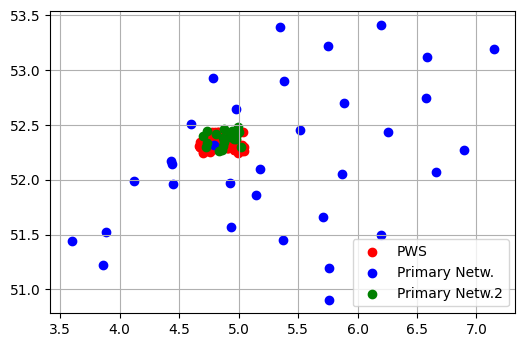

Plotting locations in and around AMS


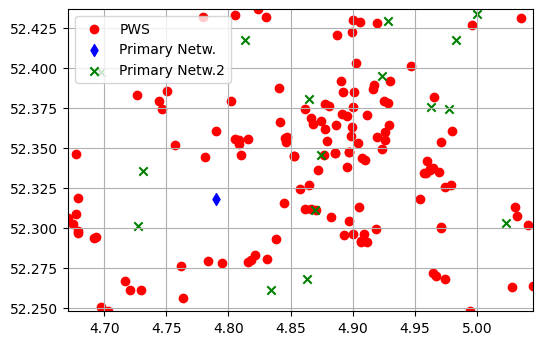

In [24]:
print('Plotting locations')

plot_pws_prim_netz_loc(lon_pws=df_pws_coords.lon,
                       lat_pws=df_pws_coords.lat,
                      lon_prim1=df_prim_coords.lon,
                       lat_prim1=df_prim_coords.lat,
                      lon_prim2=df_prim_coords_2.lon,
                       lat_prim2=df_prim_coords_2.lat)
print('Plotting locations in and around AMS')

plot_pws_prim_netz_loc_AMS(lon_pws=df_pws_coords.lon,
                       lat_pws=df_pws_coords.lat,
                      lon_prim1=df_prim_coords.lon,
                       lat_prim1=df_prim_coords.lat,
                      lon_prim2=df_prim_coords_2.lon,
                       lat_prim2=df_prim_coords_2.lat)
    


  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

Calculating indicator correlation


  0%|                                                                                          | 0/133 [00:00<?, ?it/s]C:\Users\hachem\Desktop\WPy64-3880\python-3.8.8.amd64\lib\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\hachem\Desktop\WPy64-3880\python-3.8.8.amd64\lib\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|████████████████████████████████████████████████████████████████████████████████| 133/133 [00:07<00:00, 18.45it/s]


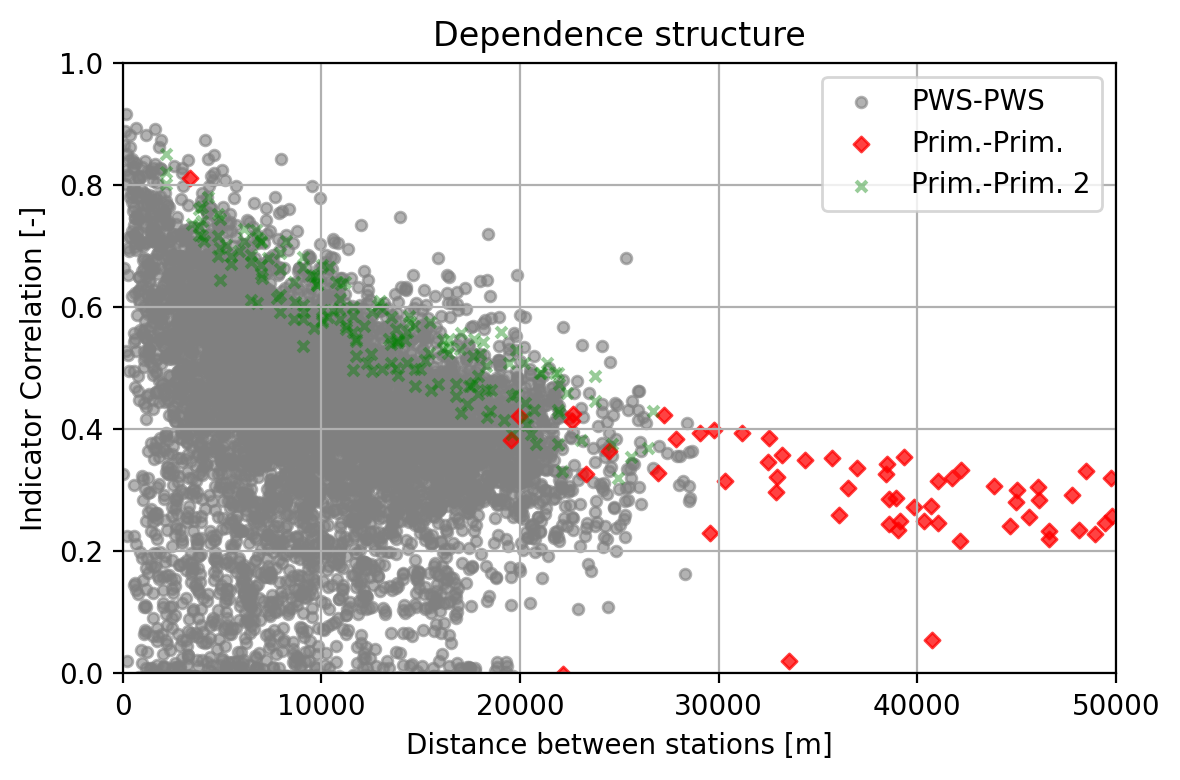

In [25]:
# PLOT indicator correlation values different networks
# calculate indicator correlation primary network
print('Calculating indicator correlation')
dist_prim, corr_prim = calc_indic_corr_all_stns(
                             coords_stns_xy=prim_coords_xy,
                             pcp_vals=in_primary_pcp.values)

# calculate indicator correlation second primary network
dist_prim2, corr_prim2 = calc_indic_corr_all_stns(
    coords_stns_xy=prim_coords_xy_2,
    pcp_vals=in_primary_pcp_2.values)

# claculate indicator correlation PWS-PWS
dist_pws, corr_pws = calc_indic_corr_all_stns(
                    coords_stns_xy=pws_coords_xy,
                         pcp_vals=df_pws_pcp_hourly.values)

plot_indic_coor(dist_prim=dist_prim,
                corr_prim=corr_prim,
                dist_pws=dist_pws,
               corr_pws=corr_pws,
               dist_prim2=dist_prim2,
               corr_prim2=corr_prim2)

100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [00:20<00:00,  6.61it/s]


Total Accepted 85 134


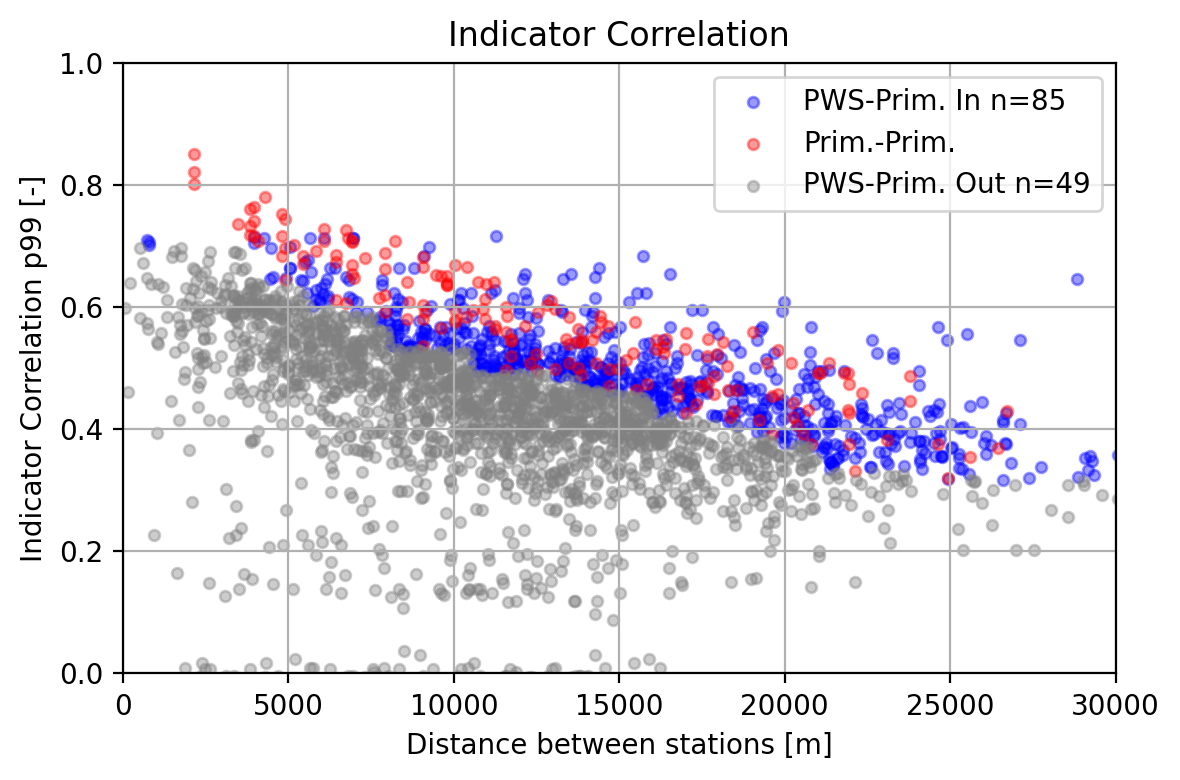

In [26]:
# apply indicator filter

stn_in = indicator_filter(xy_net=pws_coords_xy,
                 prc_net=df_pws_pcp_hourly,
                 xy_dwd=prim_coords_xy_2,
                 prc_dwd=in_primary_pcp_2,
                     prob=0.99, max_distance=50000,
                     min_req_ppt_vals=2*24*30, show_plot=True,
                     fn_figure='Indicator Correlation',
                     save_folder=None,
                    tolerance=.99)



In [27]:
pws_ids_accepted = df_pws_pcp_hourly.columns[np.where(stn_in==True)]
pws_ids_accepted

Index(['ams1', 'ams2', 'ams3', 'ams4', 'ams5', 'ams6', 'ams7', 'ams8', 'ams9',
       'ams10', 'ams12', 'ams13', 'ams14', 'ams15', 'ams17', 'ams18', 'ams19',
       'ams20', 'ams21', 'ams23', 'ams24', 'ams26', 'ams28', 'ams29', 'ams30',
       'ams31', 'ams32', 'ams33', 'ams34', 'ams35', 'ams36', 'ams39', 'ams40',
       'ams43', 'ams47', 'ams51', 'ams52', 'ams53', 'ams54', 'ams56', 'ams57',
       'ams62', 'ams65', 'ams66', 'ams69', 'ams71', 'ams72', 'ams75', 'ams78',
       'ams79', 'ams81', 'ams82', 'ams86', 'ams88', 'ams89', 'ams90', 'ams91',
       'ams94', 'ams95', 'ams96', 'ams98', 'ams100', 'ams101', 'ams102',
       'ams103', 'ams104', 'ams106', 'ams107', 'ams108', 'ams109', 'ams111',
       'ams113', 'ams114', 'ams115', 'ams117', 'ams118', 'ams120', 'ams123',
       'ams125', 'ams128', 'ams129', 'ams131', 'ams132', 'ams133', 'ams134'],
      dtype='object')

100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:03<00:00, 25.38it/s]


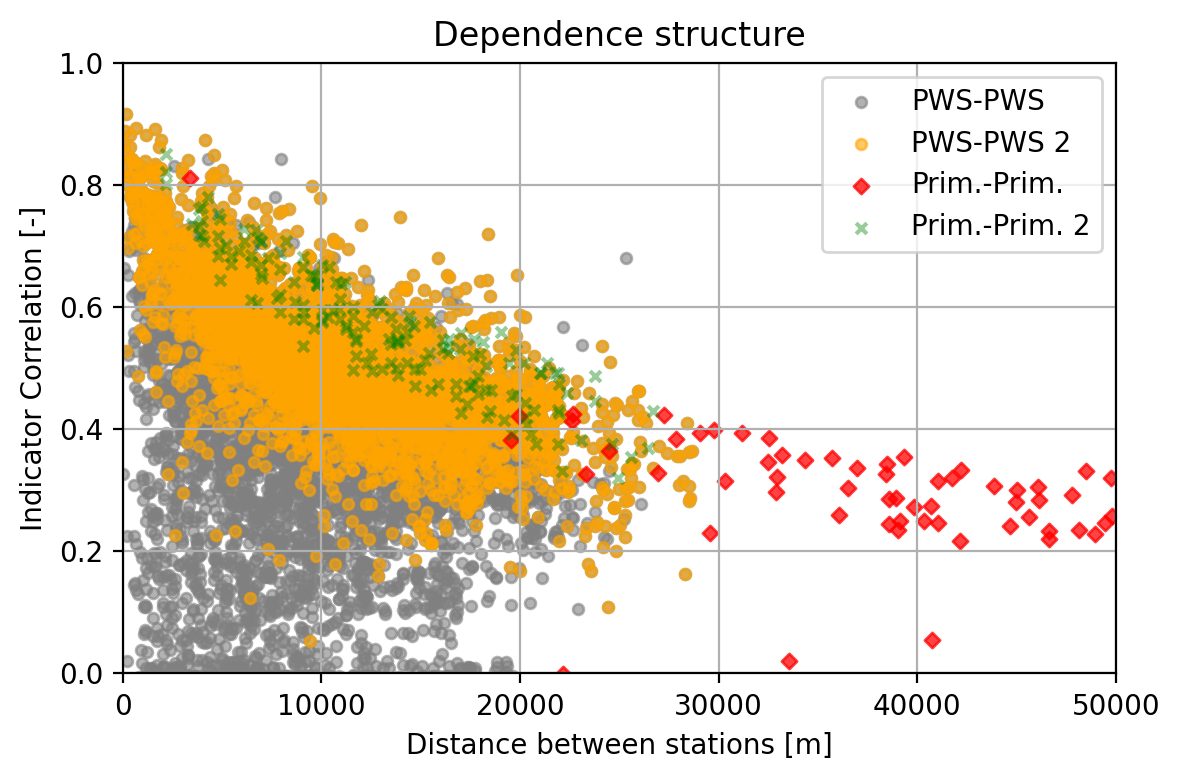

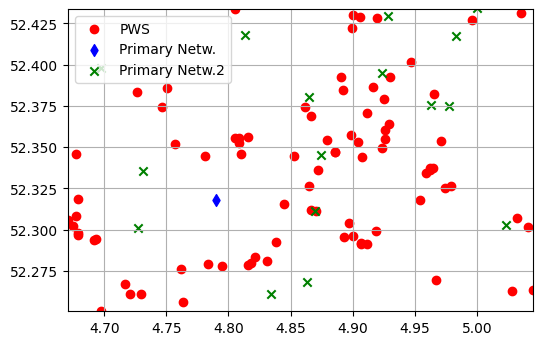

In [28]:
# claculate indicator correlation PWS-PWS
dist_pws_after, corr_pws_after = calc_indic_corr_all_stns(
    coords_stns_xy=pws_coords_xy[np.where(stn_in==True)],
                         pcp_vals=df_pws_pcp_hourly.loc[:,pws_ids_accepted].values)

plot_indic_coor(dist_prim=dist_prim,
                corr_prim=corr_prim,
                    dist_pws=dist_pws,
                   corr_pws=corr_pws,
               dist_prim2=dist_prim2,
               corr_prim2=corr_prim2,
               dist_pws_after=dist_pws_after,
               corr_pws_after=corr_pws_after)

plot_pws_prim_netz_loc_AMS(lon_pws=df_pws_coords.loc[pws_ids_accepted, 'lon'],
                           lat_pws=df_pws_coords.loc[pws_ids_accepted, 'lat'],
                          lon_prim1=df_prim_coords.lon,
                           lat_prim1=df_prim_coords.lat,
                          lon_prim2=df_prim_coords_2.lon,
                           lat_prim2=df_prim_coords_2.lat)

## Apply Bias Correction

The goal is to correct the PWS distribution function usind the distribution function of neighboring primary network stations.
For this the ranks of the PWS data and the corresponding precipitation values in the primary network

In [29]:
new_prc = bias_correct(xy_net=pws_coords_xy,
                       prc_net=df_pws_pcp_hourly.values,
                       xy_prim=prim_coords_xy_2,
                       prc_prim=in_primary_pcp_2.values,
                           stn_in_bool=stn_in)

df_corrrected = pd.DataFrame(index=df_pws_pcp_hourly.index,
                              data=new_prc,
                              columns =df_pws_pcp_hourly.columns)

  0%|                                                                                          | 0/134 [00:00<?, ?it/s]<ipython-input-14-777a176bfab0>:32: RuntimeWarning: invalid value encountered in multiply
  c = Sill * 1.0 / fac2 * fac1**v * Kv(v, fac1)
100%|███████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 451.45it/s]


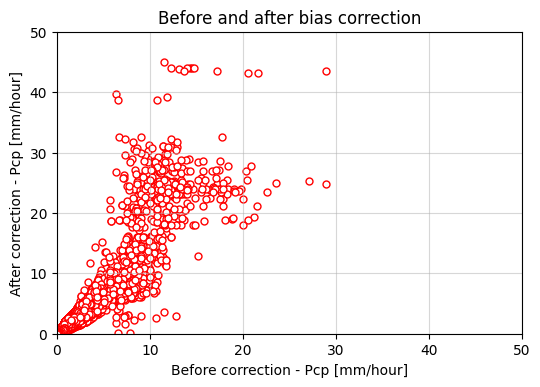

In [30]:
# plot results after bias correction
plt.figure(dpi=100)
plt.title('Before and after bias correction')
plt.scatter(
    df_pws_pcp_hourly.iloc[:, stn_in].values,
    df_corrrected.iloc[:, stn_in].values,
    edgecolor='r',
    facecolor='w',
    marker='o',
s=25)



plt.plot([0, max(df_pws_pcp_hourly.values.max(),
    df_corrrected.values.max())],
        [0, max(df_pws_pcp_hourly.values.max(),
    df_corrrected.values.max())],
        c='grey',
        linestyle='-.')

plt.xlim([0, 50])
plt.ylim([0, 50])

plt.xlabel('Before correction - Pcp [mm/hour]')
plt.ylabel('After correction - Pcp [mm/hour]')
plt.grid(alpha=0.5)     
        
